Exercises:
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

There are many things to try:
- [x] Train longer
- [X] Play with the size of the neural net (hidden layer)
- [X] Increase the number of characters as input
- [X] Change dimensionality of embedding lookup table
- [X] better batch size
- [X] better learning rate decay

In [63]:
# Hyperparameters
block_size = 4 # context length: how many characters do we take to predict the next one?
char_embedding_size = 15
hidden_layer_size = 300
batch_size = 128

In [64]:
# build the dataset

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182424, 4]) torch.Size([182424])
torch.Size([22836, 4]) torch.Size([22836])
torch.Size([22886, 4]) torch.Size([22886])


In [65]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, char_embedding_size), generator=g)
W1 = torch.randn((block_size * char_embedding_size, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [66]:
sum(p.nelement() for p in parameters) # number of parameters in total

26832

In [67]:
for p in parameters:
  p.requires_grad = True

In [68]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [69]:
lri = []
lossi = []
stepi = []

In [70]:
# import torch.optim.lr_scheduler.StepLR
optimizer = torch.optim.SGD(parameters, lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50000, gamma=0.5)

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]] # (batch_size, block_size, char_embedding_size)
  h = torch.tanh(emb.view(-1,  block_size * char_embedding_size) @ W1 + b1) # (batch_size, hidden_layer_size)
  logits = h @ W2 + b2 # (batch_size, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  # for p in parameters:
  #   p.grad = None
  optimizer.zero_grad()
  loss.backward()
  # update parameters
  optimizer.step()
  scheduler.step()

  # update
  #lr = lrs[i]
  # lr = 0.1 if i < 100000 else 0.01
  # for p in parameters:
  #   p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [75]:
optimizer.param_groups[0]['lr']

0.00625

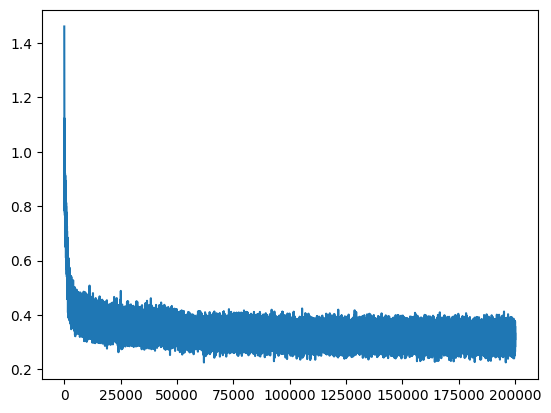

In [71]:
plt.plot(stepi, lossi)

In [72]:
# training loss
emb = C[Xtr] # (len(Xtr), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xtr), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xtr), 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0918, grad_fn=<NllLossBackward0>)

In [73]:
# validation loss
emb = C[Xdev] # (len(Xdev), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xdev), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xdev), 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1586, grad_fn=<NllLossBackward0>)

In [74]:
# test loss
emb = C[Xte] # (len(Xte), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xte), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xte), 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1652, grad_fn=<NllLossBackward0>)

In [ ]:
# # visualize dimensions 0 and 1 of the embedding matrix C for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

In [ ]:
# # sample from the model
# g = torch.Generator().manual_seed(2147483647 + 10)

# for _ in range(20):
    
#     out = []
#     context = [0] * block_size # initialize with all ...
#     while True:
#       emb = C[torch.tensor([context])] # (1,block_size,d)
#       h = torch.tanh(emb.view(1, -1) @ W1 + b1)
#       logits = h @ W2 + b2
#       probs = F.softmax(logits, dim=1)
#       ix = torch.multinomial(probs, num_samples=1, generator=g).item()
#       context = context[1:] + [ix]
#       out.append(ix)
#       if ix == 0:
#         break
    
#     print(''.join(itos[i] for i in out))

## E02: I was not careful with the intialization of the network in this video.
(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?<br/>
(2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [35]:
# Hyperparameters
from typing import Callable


block_size = 3 # context length: how many characters do we take to predict the next one?
char_embedding_size = 10
hidden_layer_size = 200
batch_size = 32

initialization: Callable[[tuple[int], torch.Generator], torch.Tensor] = torch.randn  # torch.zeros
uniformization: Callable[[torch.Tensor], torch.Tensor] | None = None # torch.nn.init.xavier_uniform_  # or xavier_uniform_

In [45]:
# build the dataset

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  # if torch.cuda.is_available():
  #   X = X.cuda()
  #   Y = Y.cuda()
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [58]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# Make C more uniform
C = initialization((27, char_embedding_size), generator=g)
W1 = initialization((block_size * char_embedding_size, hidden_layer_size), generator=g)
b1 = initialization(hidden_layer_size, generator=g)
W2 = initialization((hidden_layer_size, 27), generator=g)
b2 = initialization(27, generator=g)

# if torch.cuda.is_available():
#   C = C.cuda()
#   W1 = W1.cuda()
#   b1 = b1.cuda()
#   W2 = W2.cuda()
#   b2 = b2.cuda()
parameters: list[torch.Tensor] = [C, W1, b1, W2, b2]

if uniformization is not None:
  for p in parameters:
    old_shape = p.shape
    uniformization(p)
    assert p.shape == old_shape



print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

11897


In [59]:
lossi = []
stepi = []

In [60]:
# import torch.optim.lr_scheduler.StepLR
# optimizer = torch.optim.SGD(parameters, lr=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50000, gamma=0.5)

for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]  # (batch_size, block_size, char_embedding_size)
    h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1)  # (batch_size, hidden_layer_size)
    logits = h @ W2 + b2  # (batch_size, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    # optimizer.zero_grad()
    loss.backward()
    # update parameters
    # optimizer.step()
    # scheduler.step()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

In [74]:
# %load_ext line_profiler

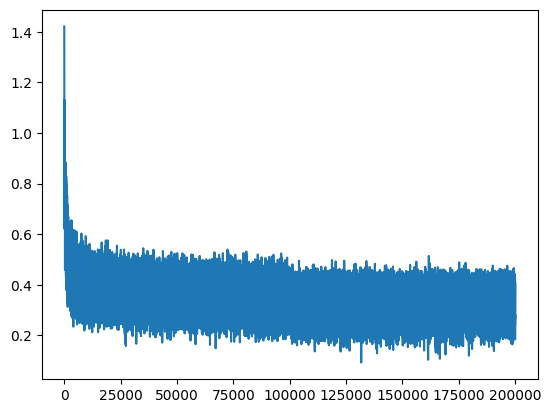

In [61]:
plt.plot(stepi, lossi)

In [40]:
# training loss
emb = C[Xtr] # (len(Xtr), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xtr), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xtr), 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1250, grad_fn=<NllLossBackward0>)

In [41]:
# validation loss
emb = C[Xdev] # (len(Xdev), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xdev), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xdev), 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1630, grad_fn=<NllLossBackward0>)

In [42]:
# test loss
emb = C[Xte] # (len(Xte), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xte), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xte), 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1664, grad_fn=<NllLossBackward0>)

## E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

Paper definitions:
- `V` is the vocabulary
- `h` is the number of hidden units
- `m` the number of features associated with each word (embedding vector size)
- `n` is the number of previous words used as features (context size)
- `direct`: whether there are direct connections from word features to outputs
- `mix`: whether the output probabilities of the neural network are mixed with the output of the trigram (with a weight of 0.5 on each).

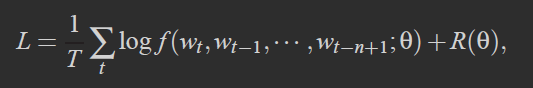

Things mentioned in the paper:
- `y = b + Wx + Utanh(d + Hx)`
    - `W` is optionally zero (no direct connections)
    - `x` is the word features layer activation vector, which is the concatenation of the input word features from the matrix `C`:<br/>
        `x = (C(wt−1), C(wt−2), ..., C(wt−n+1))`
    - `b` (with `|V|` elements)
    - `d` (with `h` elements)
    - the hidden-to-output weights `U` (a `|V| x h` matrix)
    - the word features to output weights `W` (a `|V| x (n−1)m` matrix)
    - the word features `C` (a `|V| x m` matrix)
    - all the parameters are `theta = (b, d, W, U, H, C)`

- Weight decay regularization (between `10-4` and `10-5`)
    - "*Like in ridge regression, the squared norm of the parameters is penalized.*"
    - "*(by subtracting the weight decay factor times the learning rate times the value of the parameter, from each parameter, at each update)*"
- the initial learning rate was set to `e0 = 10−3`, and gradually decreased according to the following schedule:<br/>
    `et = e0/(1+rt)` where `t` represents the step number and `r` is a decrease factor that was chosen to be `r = 10−8`

Results table:
<table>
    <tr>
        <th>Model</th>
        <th>n</th>
        <th>h</th>
        <th>m</th>
        <th>direct</th>
        <th>mix</th>
    </tr>
    <tr>
        <td>MLP1</td>
        <td>5</td>
        <td>50</td>
        <td>60</td>
        <td>yes</td>
        <td>no</td>
    </tr>
    <tr>
        <td>MLP2</td>
        <td>5</td>
        <td>50</td>
        <td>60</td>
        <td>yes</td>
        <td>yes</td>
    </tr>
    <tr>
        <td>MLP3</td>
        <td>5</td>
        <td>50</td>
        <td>60</td>
        <td>yes</td>
        <td>no</td>
    </tr>
    <tr>
        <td>...</td>
        <td>...</td>
        <td>...</td>
        <td>...</td>
        <td>...</td>
        <td>...</td>
    </tr>
 

In [15]:
# Hyperparameters
from typing import Callable


block_size = 3 # context length: how many characters do we take to predict the next one?
char_embedding_size = 10
hidden_layer_size = 200
batch_size = 32
regularization = 1e-3


initialization: Callable[[tuple[int], torch.Generator], torch.Tensor] = torch.randn  # torch.zeros
uniformization: Callable[[torch.Tensor], torch.Tensor] | None = None # torch.nn.init.xavier_uniform_  # or xavier_uniform_

direct = True


In [7]:
# build the dataset

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  # if torch.cuda.is_available():
  #   X = X.cuda()
  #   Y = Y.cuda()
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
# Make C more uniform
C: torch.Tensor = initialization((27, char_embedding_size), generator=g)
W1 = initialization((block_size * char_embedding_size, hidden_layer_size), generator=g)
b1 = initialization(hidden_layer_size, generator=g)
W2 = initialization((hidden_layer_size, 27), generator=g)
b2 = initialization(27, generator=g)

parameters: list[torch.Tensor] = [C, W1, b1, W2, b2]

if direct:
    # `(n−1)m x |V|`
    Wd = initialization((block_size * char_embedding_size, 27), generator=g)
    parameters.append(Wd)

if uniformization is not None:
    for p in parameters:
        old_shape = p.shape
        uniformization(p)
        assert p.shape == old_shape


print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

12707


In [17]:
lossi = []
stepi = []

In [18]:
# optimizer = torch.optim.SGD(parameters, lr=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50000, gamma=0.5)

for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]  # (batch_size, block_size, char_embedding_size)
    h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1)  # (batch_size, hidden_layer_size)
    logits = h @ W2 + b2  # (batch_size, 27)
    if direct:
        logits += emb.view(-1, block_size * char_embedding_size) @ Wd
    # compute Ridge regularization term
    ridge_term = 0
    if regularization > 0:
        ridge_parameters: list[torch.Tensor] = [W1, W2]
        if direct:
            ridge_parameters.append(Wd)
        ridge_term = regularization * sum(torch.sum(param**2) for param in ridge_parameters)
    loss = F.cross_entropy(logits, Ytr[ix]) + ridge_term
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    # optimizer.zero_grad()
    loss.backward()
    # update parameters
    # optimizer.step()
    # scheduler.step()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

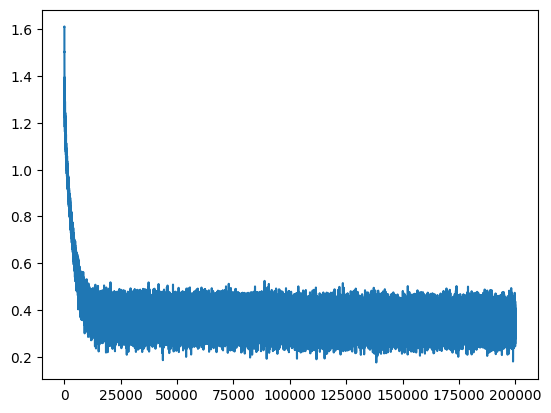

In [19]:
plt.plot(stepi, lossi)

In [20]:
# training loss
emb = C[Xtr] # (len(Xtr), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xtr), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xtr), 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4565, grad_fn=<NllLossBackward0>)

In [21]:
# validation loss
emb = C[Xdev] # (len(Xdev), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xdev), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xdev), 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4590, grad_fn=<NllLossBackward0>)

In [22]:
# test loss
emb = C[Xte] # (len(Xte), block_size, char_embedding_size)
h = torch.tanh(emb.view(-1, block_size * char_embedding_size) @ W1 + b1) # (len(Xte), hidden_layer_size)
logits = h @ W2 + b2 # (len(Xte), 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4634, grad_fn=<NllLossBackward0>)